# Bad Commit Predictor , Which Check-Ins are Bad Ones?

![](./images/img1.gif)

# Problem Statement 
## Bussiness Objective 
In Software (SW) Industry, development teams are working together to develop, integrate, test and deploy SW incrementally toward the final end products. In large SW houses , code is managed by configuration management system to control code versions among distributed working groups who may be placed in different geographic areas. Every day, new code increments are developed by development team, regression test in triggered to assure that the new changes do not break already workable code. If the regression tests fail, human intervention is a must to identify root cause of the failure and do the fix. the fix can be revert bad code commits, update test due to new behavior changes or file defect report and disable the test until the bug fix. 

The process of identify the root cause of the failure, make corrective action is time consuming and can slow down development pipeline or continuous integration , test, deployment of software code.

ML can be used to predict if the upcoming code changes are risky or not (will results in regression failure), to prevent the check-in until assure all tests pass locally before code integration to product branch. 

Another field of use of ML-Based bad Check-In predictor is that when test fails, the list of code commits between first fail and last pass can be provided to the predictor to identify the culprit bad commits, and hence help in identify root cause of the failure of regression test hence reduce the TAT between bug injection and bug detection in the SW development cycle.

## Data Source and Extraction 
The Dataset used here is extracted from Open-HW platforms for 3 Projects in GitHub
- Open Titan : https://github.com/lowRISC/opentitan
- Open Ibex : https://github.com/lowRISC/ibex
- CVA6 : https://github.com/openhwgroup/cva6
- Our Own , Extractor is used to extract from github metadata , list of features we beleiev may contribute in predicting the good/bad code commits as refered in many publications about same topic.
- Original Data Size is ( 28854 entries, 185 Coloumns Size of 40 MB) 

## Data Reading & Feature List 
- Project : Project ID Titan, Ibex, CVA6, In-House (1,2,3,4)
- id : Code Commit CL Number
- author : Author of Code Change
- commit_message : github Commit Message
- hour_of_day : Hour of Day when code commit submitted 
- day_of_week : Day of the Week when code commit submitted 
- week_of_month : Week of the Month when code commit submitted 
- month_of_year : Month of Year wehn code commit submitted 
- is_fix : Was the Code Check-Ins for Bug Fix?
- num_affected_files : No of Filed Affected by the Change 
- num_affected_dirs : No of Affected Directories by the Change
- num_rtl_files : No of RTL related Files
- num_files_added : Files Added 
- num_files_deleted : Filed Deleted 
- num_lines_added : Line added 
- num_lines_deleted : Line deleted 
- comments_added : No of Comment Lines Added
- comments_deleted : No of Comment Lines Deleted 
- blank_lines_added : No of Blank Lines Added 
- blank_lines_deleted : No of Blank Lines Deleted 
- type_changed : Type of Change : Source Code, Documentation, Others 
- file_complexity_max : Complexity of Changed File
- nested_cond_file_max : Nested Conditions in the Changed File
- nested_loops_file_max : Nested Loops in the Changed File
- commits_per_file_max : No of Commits per File (as Indictaion for amount of changable Files )
- failures_per_file_max : No of Bad Commits Submitted for this File
- ext_modules_max : External Modules (No of Instantiated Modules)
- nested_cond_add_max : Added Code Complexity ( Conditions)
- nested_loops_add_max : Added Code Complexity (Nested Loops)
- import_modules_max : No of Included Files in Changed File
- avg_nest_lvl_cond_added_max : Added Code Compelxity (Level of Nested Conditions)
- avg_nest_lvl_loop_added_max : Added Code Complexity (Level of Nested Loops)
- complexity_added_max : Added Code Cyclomatic Complexity
- avg_nest_lvl_cond_file_max : File Complexity (Level of Nested Conditions)
- avg_nest_lvl_loop_file_max : File Complexity (Level of Nested Loop)
- author_commits_on_files_max : Author Experience (No of Commits he did in the File)
- author_failed_commits_on_files_max : Author Experience (No of Bad Commits he did in File)
- is_bad : Target Variable (Was this Bad Commit or Not )

In [1]:
#Basic Lib
import pandas as pd
import numpy as np

#Visualization Lib
import matplotlib.pyplot as plt
import seaborn as sns

#ML Models and Feature Engineering Lib 
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score  
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
%matplotlib inline

## Step1: Data Exploration 
- Drop Missed Values for Target Variable : "is_bad"
- Exclude Additional Features in Raw Data that is Aggregated in multiple Measures (Mean, Median, Mode, Min, Range,..)  
- Data Size Exploration , Feature Type (Categorical/Numerical)
- Eliminate rows with "multiple co-authors, contributors and co-author names" as they are irrelevant to problem scope

In [2]:
cols = pd.read_csv('./data/Code-Commits.csv', nrows=0).columns
type_dict = {'Project' : 'string', 'id':'string', 'author':'string', 'commiter' : 'string', 'commit_message' : 'string', 'is_fix' : 'string', 'is_bad' : 'string' , 'type_changed': 'string'\
, 'no_co_auth': 'float', 'no_contributors' : 'float', 'hour_of_day' : 'float', 'day_of_week' : 'float', 'week_of_month' : 'float', 'month_of_year' : 'float', \
**{col: 'float32' for col in cols[13:174]}}
data_df = pd.read_csv('./data/Code-Commits.csv',dtype= type_dict)
data_df.head(5)

Project                                        id  no_co_auth  \
0       1  641c6a27a8095276f5af160cc159c3ec328e97d2         0.0   
1       1  eac5f3c62f895d70c86625fd55aff502dd543bde         0.0   
2       1  731f442bd0935589a858f39bce8781550f6f0366         0.0   
3       1  e9d3248302cf1806c6314efd554f53d9a19bb6da         0.0   
4       1  965e7569cbe23a405a0360154cc4113cf52d4acd         0.0   

            author         commiter  no_contributors  \
0  Mostafa  Hassan  Mostafa  Hassan              1.0   
1  Mostafa  Hassan  Mostafa  Hassan              1.0   
2  Mostafa  Hassan  Mostafa  Hassan              1.0   
3  Mostafa  Hassan  Mostafa  Hassan              1.0   
4  Mostafa  Hassan  Mostafa  Hassan              1.0   

                                      commit_message  hour_of_day  \
0                                ['Fix bad changes']         10.0   
1  ['Good Changes :', 'Exchanged some operand for...         18.0   
2  ['Good Changes :', 'Exchanged some operand for...         18.0   
3  ['Good Changes :', 'Replaced the modules of th...         18.0   
4  ['Good Changes :', 'Replaced the modules of th...         17.0   

   day_of_week  week_of_month  ...  author_failed_commits_on_files_median  \
0          1.0            4.0  ...                               1.732143   
1          2.0            2.0  ...                               2.333333   
2          2.0            2.0  ...                               4.000000   
3          2.0            2.0  ...                               2.666667   
4          2.0            2.0  ...                               2.023810   

  author_failed_commits_on_files_mode author_failed_commits_on_files_max  \
0                            1.363636                           2.250000   
1                            1.000000                           3.666667   
2                            4.000000                           4.000000   
3                            2.666667                           2.666667   
4                            0.714286                           3.333333   

   author_failed_commits_on_files_min  author_failed_commits_on_files_range  \
0                            1.363636                              0.886364   
1                            1.000000                              2.666667   
2                            4.000000                              0.000000   
3                            2.666667                              0.000000   
4                            0.714286                              2.619048   

   author_failed_commits_on_files_25th_percentile  \
0                                        1.553571   
1                                        1.666667   
2                                        4.000000   
3                                        2.666667   
4                                        1.369048   

   author_failed_commits_on_files_75th_percentile  \
0                                        1.879808   
1                                        3.000000   
2                                        4.000000   
3                                        2.666667   
4                                        2.678571   

   author_failed_commits_on_files_interquartile_range  \
0                                           0.326236    
1                                           1.333333    
2                                           0.000000    
3                                           0.000000    
4                                           1.309524    

   author_failed_commits_on_files_std  is_bad  
0                            0.286650    <NA>  
1                            1.333333    <NA>  
2                            0.000000    <NA>  
3                            0.000000    <NA>  
4                            1.309524    <NA>  

[5 rows x 185 columns]

In [3]:
# Drop NA from Target Variable, Un-Labeled Data 
data_df.dropna(subset = ['is_bad'], inplace = True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4736 entries, 76 to 16693
Columns: 185 entries, Project to is_bad
dtypes: float32(161), float64(16), string(8)
memory usage: 3.8 MB


In [4]:
#supress_list = ['_mean', '_median', '_mode' , '_min', '_range', '_25th_percentile', '_75th_percentile', '_interquartile_range', '_file_complexity_std']
# Supress Coloumn with agrregation rather than max 
data_df.drop(list(data_df.filter(regex='_mean|_median|_mode|_min|_range|_25th_percentile|_75th_percentile|_interquartile_range|_std')), axis=1, inplace=True)

In [5]:
data_df.head(10)
data_df.drop(['no_co_auth', 'commiter', 'no_contributors'], axis=1, inplace=True)


In [6]:
data_df.to_csv("./data/data_clean.csv")

In [7]:
data = data_df[data_df['num_rtl_files'] != 0]

In [8]:
# Build a list of coloumns with numeric, categorical values
num_data = data.select_dtypes(include=np.number) 
num_col = num_data.columns     
cat_data = data.select_dtypes(exclude=np.number) 
cat_col = cat_data.columns
print("===="*10)
print("Numeric Features:")
print(num_col)
print("===="*10)
print("Categorical Features:")
print(cat_col)
print("===="*10)

Numeric Features:
Index(['hour_of_day', 'day_of_week', 'week_of_month', 'month_of_year',
       'num_affected_files', 'num_affected_dirs', 'num_rtl_files',
       'num_files_added', 'num_files_deleted', 'num_lines_added',
       'num_lines_deleted', 'comments_added', 'comments_deleted',
       'blank_lines_added', 'blank_lines_deleted', 'file_complexity_max',
       'nested_cond_file_max', 'nested_loops_file_max', 'commits_per_file_max',
       'failures_per_file_max', 'ext_modules_max', 'nested_cond_add_max',
       'nested_loops_add_max', 'import_modules_max',
       'avg_nest_lvl_cond_added_max', 'avg_nest_lvl_loop_added_max',
       'complexity_added_max', 'avg_nest_lvl_cond_file_max',
       'avg_nest_lvl_loop_file_max', 'author_commits_on_files_max',
       'author_failed_commits_on_files_max'],
      dtype='object')
Categorical Features:
Index(['Project', 'id', 'author', 'commit_message', 'is_fix', 'type_changed',
       'is_bad'],
      dtype='object')


In [9]:
## Check Null Values After Clean-Up
data.isnull().sum().sort_values()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2159 entries, 76 to 16693
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Project                             2159 non-null   string 
 1   id                                  2159 non-null   string 
 2   author                              2159 non-null   string 
 3   commit_message                      2159 non-null   string 
 4   hour_of_day                         2159 non-null   float64
 5   day_of_week                         2159 non-null   float64
 6   week_of_month                       2159 non-null   float64
 7   month_of_year                       2159 non-null   float64
 8   is_fix                              2159 non-null   string 
 9   type_changed                        2159 non-null   string 
 10  num_affected_files                  2159 non-null   float32
 11  num_affected_dirs                   2159 

## Step2: Features Exploration here we utilized multiple Feature Exploration Approaches 
- Filter Methods : 
  - Basic Methods: Uni-Variable to Target Vraible Relations
  - Correlation Matrix, HeatMap.

In [10]:
# Step1: Identify Target Variable and Class Imbalance
# Results demonstrate that the data set has imbalanced classes with 11% only belongs to positive class.
data['is_bad'].value_counts(dropna=False)
pos_class_ratio = (data.loc[data['is_bad'] == '1'].shape[0]/data.shape[0])* 100
print ("Ratio of Bad Commits vs Good Commits in Our Data Sets", pos_class_ratio, "%")

Ratio of Bad Commits vs Good Commits in Our Data Sets 22.417786012042612 %


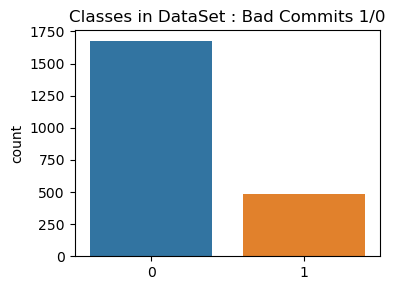

In [11]:
plt.figure(figsize=(4,3))
sns.countplot(data = data, x = 'is_bad')
plt.xlabel('')
plt.title('Classes in DataSet : Bad Commits 1/0')
plt.tight_layout();
plt.show()

## 2.1 Categorical Features Relevance to Target Variable

In [12]:
cat_col_relevant = []
cat_col_relevant = ['Project','is_fix', 'type_changed']

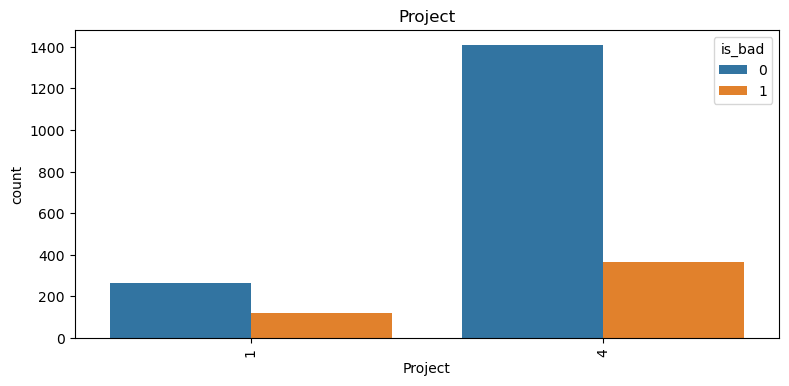

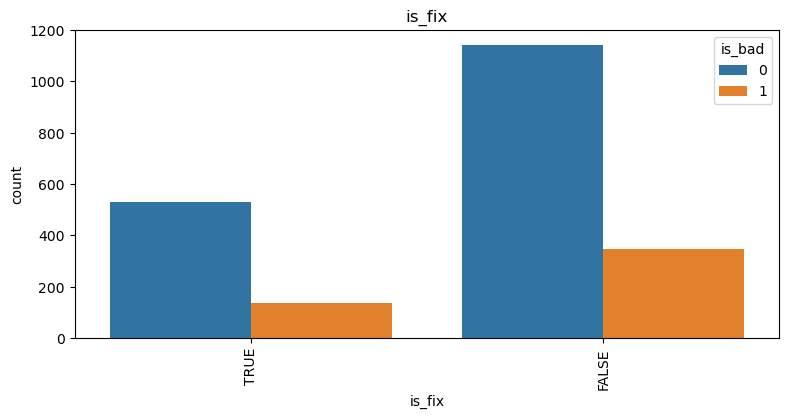

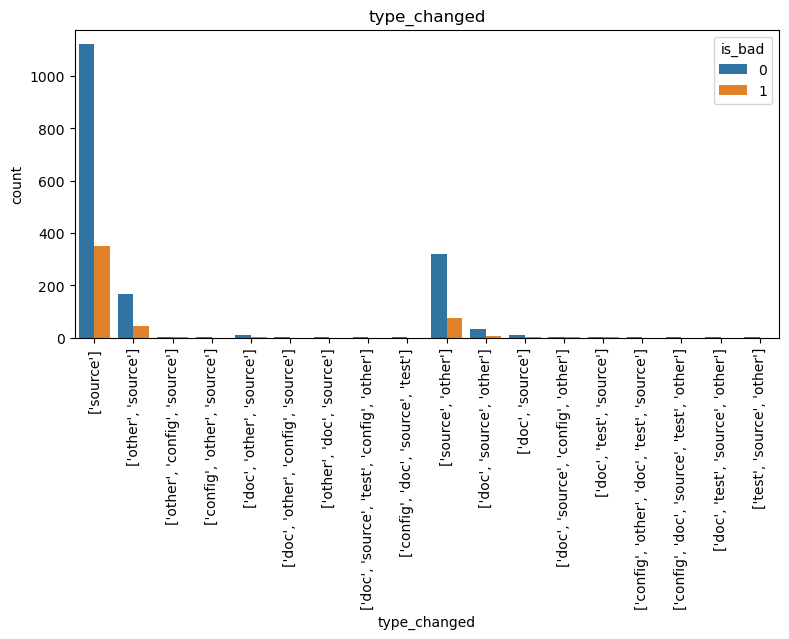

In [13]:
for column in cat_col_relevant:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(x=data[column],hue=data['is_bad'],data=data)
    plt.title(column)    
    plt.xticks(rotation=90)
    plt.show()

## 2.2 Numerical Features Distribution / Variation & Their Correlation Matrix/Map
- Check Distribution

In [14]:
data.to_csv("./data/data_clean.csv")

C:\Users\m3naej\AppData\Local\Temp\ipykernel_44096\2579199696.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(column=num_col, ax=ax)


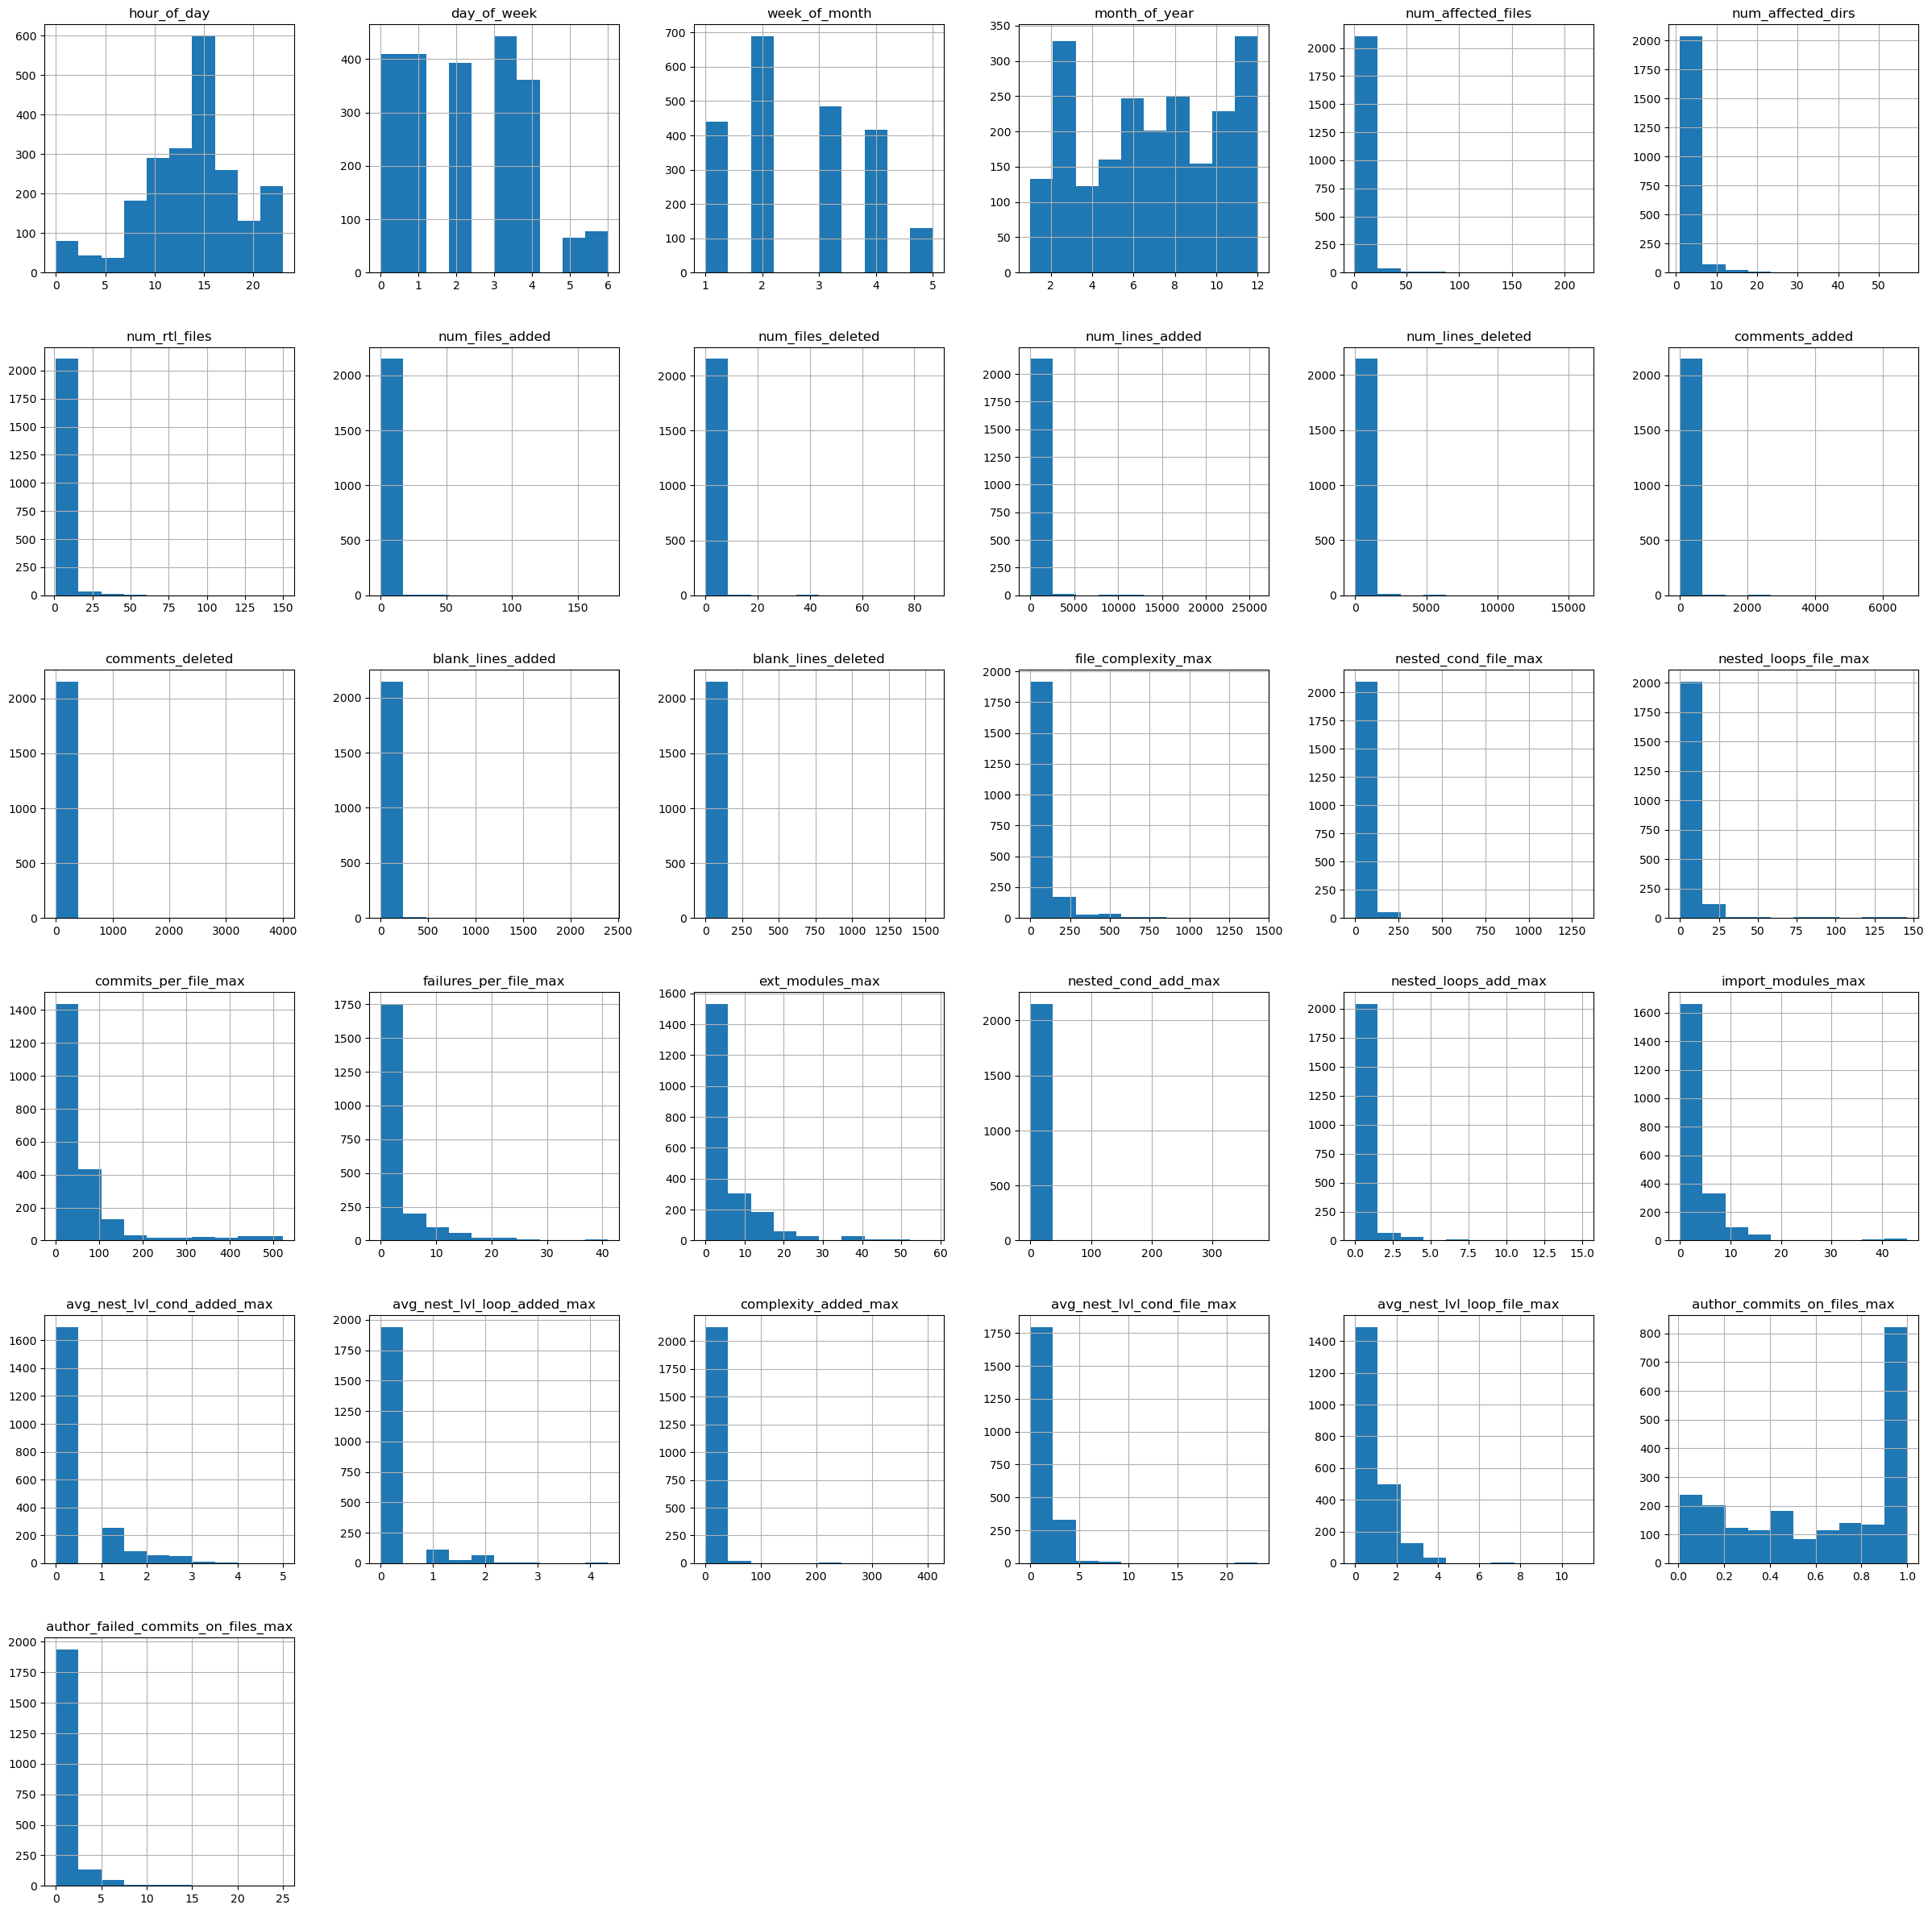

In [15]:
#for Variable in (num_col):
#    sns.histplot(data, x=data[variable],hue = data['is_bad'])
fig, axs = plt.subplots(2, 2, figsize=(30,30))
for ax, col in zip(axs.flatten(), num_col):
    data.hist(column=num_col, ax=ax)
    #px.histogram(data, x=num_col, color= 'is_bad')

In [16]:
# Check features with low variance - Variance Threshold
from sklearn.feature_selection import VarianceThreshold
vth = VarianceThreshold(threshold=0)  # as deafult threshold=0
vth.fit(data[num_col])
data_vth = data[num_col].iloc[:, vth.get_support()]

Feature_Var = pd.DataFrame( {'Feature': data[num_col].columns,'Variance': vth.variances_,}).sort_values('Variance', ascending=True)
Feature_Var.head(10)

Feature  Variance
29         author_commits_on_files_max  0.125373
25         avg_nest_lvl_loop_added_max  0.239119
24         avg_nest_lvl_cond_added_max  0.499109
22                nested_loops_add_max  0.906748
28          avg_nest_lvl_loop_file_max  1.049641
2                        week_of_month  1.393917
27          avg_nest_lvl_cond_file_max  2.375403
1                          day_of_week  2.623966
30  author_failed_commits_on_files_max  4.674459
8                    num_files_deleted  5.131718

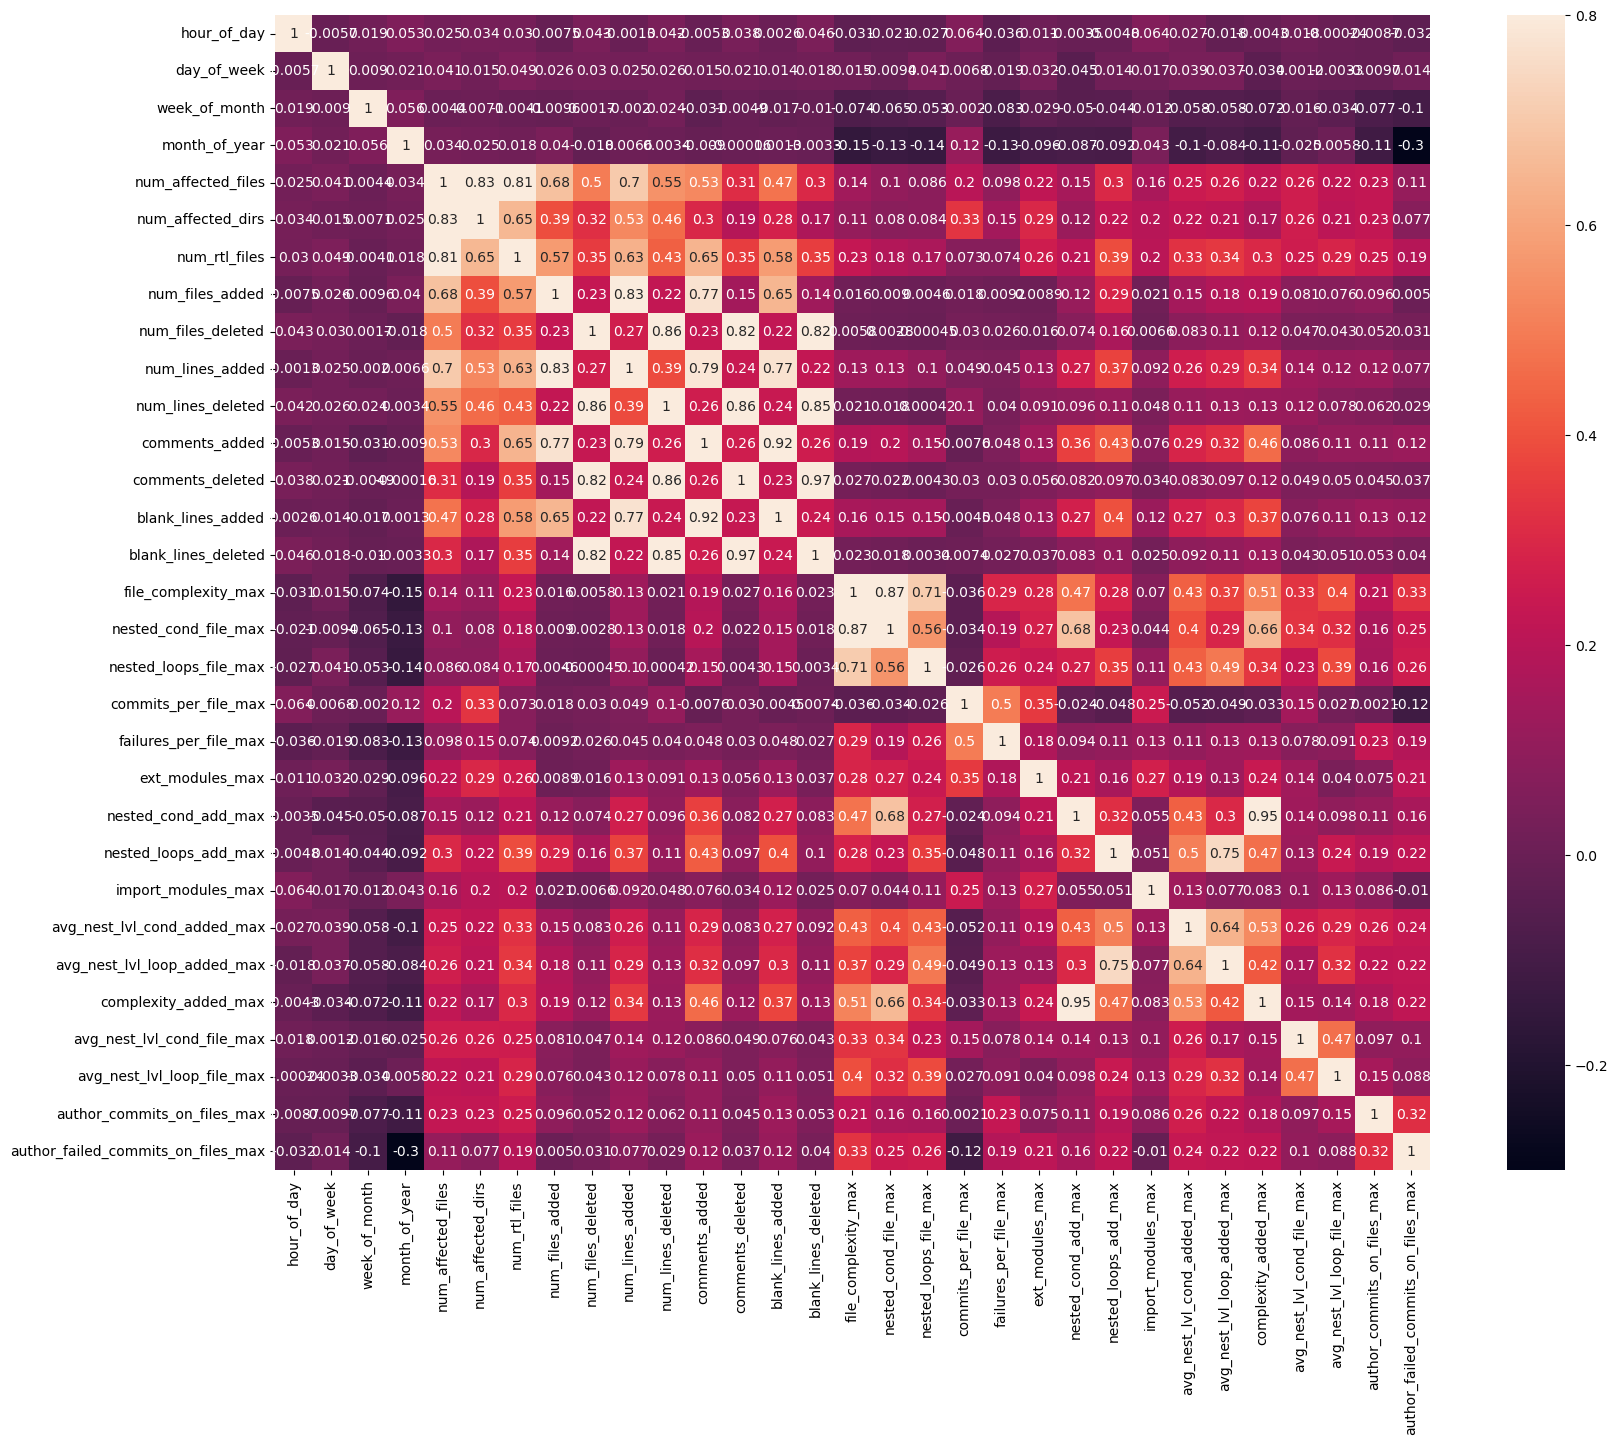

In [17]:
corrmap = data[num_col].corr()
#figsize=(12, 9)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmap, vmax=.8, square=True,annot=True );

In [18]:
### Time Consuming Step ###################
sns.pairplot(data)
plt.show();

In [19]:
upper = corrmap.where(np.triu(np.ones(corrmap.shape), k=1).astype(np.bool))
#print (upper)
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print (to_drop)

['num_lines_deleted', 'comments_deleted', 'blank_lines_added', 'blank_lines_deleted', 'nested_cond_file_max', 'complexity_added_max']


C:\Users\m3naej\AppData\Local\Temp\ipykernel_44096\1050555043.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corrmap.where(np.triu(np.ones(corrmap.shape), k=1).astype(np.bool))


## Observations & Conclusion 1
- Results demonstrate that the data set has imbalanced classes with 11% only belongs to positive class.
- Project 3, 2 has no Bad Commits only Project 1, 4 (Open Titan, In-House Project) has bad commits 
- Some Features, which we consider critical come with low variance such as 
    - author_commits_on_files_max
    - avg_nest_lvl_loop_added_max
    - avg_nest_lvl_cond_added_max
    - nested_loops_add_max
    - avg_nest_lvl_loop_file_max
    - week_of_month
    - avg_nest_lvl_cond_file_max
    - day_of_week
    - author_failed_commits_on_files_max
    - num_files_deleted
- Some Features come as high uncorrelated 
    - num_lines_deleted
    - comments_deleted
    - blank_lines_added
    - blank_lines_deleted
    - nested_cond_file_max
    - complexity_added_max

## Step3: Data Encoding 
This Data Frame has the Categorical Features
- Project : Identify the Project this Data Belongs To (1- S-Debug, 2-IBEX,3-CVA6, 4-Titan)
- id : Change List ID
- author : Name of author
- commit message : the commit message itself
- is_fix : was the commit for bug fix
- type_changed : was the commit for doc, source, test, config, other changes
- is_bad : Target Variable Yes/No

## 3.1 Encoding Step1: 
- Label Encoding for Author Name, Project
- Binary Encoding for is_fix, is_bad
- Convert type_changed to multi binary catgeorical coloumn : it reflect wether code change was Code, Test, Doc, Setup
- No need to use commit_message or CL id for now
- Standard Scaling for Numerical Data 

In [20]:
data_tmp = data

In [21]:
cat_features_1 = ['Project', 'author']
# Label Encoding for Author Name, Project
lbl_encoder = LabelEncoder()
lbl_encoded_df = data[cat_features_1].apply(lbl_encoder.fit_transform)
data = data.drop(cat_features_1, axis=1)
data = pd.concat([lbl_encoded_df, data], axis=1)

In [22]:
# MultiLabel Binary Encoding to "Type of Change"
type_change_lst = ['doc', 'source', 'test', 'config', 'other']
type_change_cols = ['type_change_doc', 'type_change_source','type_change_test','type_change_config','type_change_other']
type_change_df = pd.DataFrame(data, columns= type_change_cols).fillna(0)
data_new = pd.concat([data,type_change_df], axis = 1)
data_new.loc[data['type_changed'].str.contains('doc'), 'type_change_doc'] = 1
data_new.loc[data['type_changed'].str.contains('source'), 'type_change_source'] = 1
data_new.loc[data['type_changed'].str.contains('test'), 'type_change_test'] = 1
data_new.loc[data['type_changed'].str.contains('config'), 'type_change_config'] = 1
data_new.loc[data['type_changed'].str.contains('other'), 'type_change_other'] = 1

In [23]:
data_new.to_csv("./data/data_clean.csv")

In [24]:
data = data_new.drop('type_changed', axis=1)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2159 entries, 76 to 16693
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Project                             2159 non-null   int32  
 1   author                              2159 non-null   int32  
 2   id                                  2159 non-null   string 
 3   commit_message                      2159 non-null   string 
 4   hour_of_day                         2159 non-null   float64
 5   day_of_week                         2159 non-null   float64
 6   week_of_month                       2159 non-null   float64
 7   month_of_year                       2159 non-null   float64
 8   is_fix                              2159 non-null   string 
 9   num_affected_files                  2159 non-null   float32
 10  num_affected_dirs                   2159 non-null   float32
 11  num_rtl_files                       2159 

In [26]:
data['is_fix'].replace({'TRUE':'1', 'FALSE':'0'}, inplace=True)

In [27]:
ml_data = data.drop(['id', 'commit_message'], axis=1)

In [28]:
convert_dict = {'is_bad': int,
                'is_fix': int,
                }
 
ml_data = ml_data.astype(convert_dict)

In [29]:
# Caling Numerical Data 
ml_num_data = ml_data.select_dtypes(include=np.number) 
ml_num_col = ml_num_data.columns     
ml_cat_data = ml_data.select_dtypes(exclude=np.number) 
ml_cat_col = ml_cat_data.columns
print ("Numerical Features List", ml_num_col)
print (" Categorical Features List", ml_cat_col)

Numerical Features List Index(['Project', 'author', 'hour_of_day', 'day_of_week', 'week_of_month',
       'month_of_year', 'is_fix', 'num_affected_files', 'num_affected_dirs',
       'num_rtl_files', 'num_files_added', 'num_files_deleted',
       'num_lines_added', 'num_lines_deleted', 'comments_added',
       'comments_deleted', 'blank_lines_added', 'blank_lines_deleted',
       'file_complexity_max', 'nested_cond_file_max', 'nested_loops_file_max',
       'commits_per_file_max', 'failures_per_file_max', 'ext_modules_max',
       'nested_cond_add_max', 'nested_loops_add_max', 'import_modules_max',
       'avg_nest_lvl_cond_added_max', 'avg_nest_lvl_loop_added_max',
       'complexity_added_max', 'avg_nest_lvl_cond_file_max',
       'avg_nest_lvl_loop_file_max', 'author_commits_on_files_max',
       'author_failed_commits_on_files_max', 'is_bad', 'type_change_doc',
       'type_change_source', 'type_change_test', 'type_change_config',
       'type_change_other'],
      dtype='object')


In [30]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])
#cat_pipeline = Pipeline([("onehot", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, ml_num_col)
])

In [31]:
X, y = '', ''
X = ml_data.drop(['is_bad'], axis=1)
y = ml_data['is_bad']

## Step4: Features Selection , here we utilized multiple Feature Exploration Approaches 
- Filter Methods : 
  - Filter Methods : Features with low variance - Variance Threshold, Select KBest, Information gain, percentaile
- Model-Based Feature Selection 
- Iterative Feature Selection 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3, random_state=42)
classification_models = [
    ('LR', LogisticRegression(solver='liblinear')),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(gamma='auto')),
    ("Decision Tree", DecisionTreeClassifier())]

## Step 4.1 Low Variance Checking 

In [33]:
vth = VarianceThreshold(threshold=0)  # as deafult threshold=0
vth.fit(X_train)
X_train_vth = X_train.iloc[:, vth.get_support()]

Feature_Var = pd.DataFrame( {'Feature': X_train.columns,'Variance': vth.variances_,}).sort_values('Variance', ascending=True)
Feature_Var.head(10)

Feature  Variance
35           type_change_source  0.000000
36             type_change_test  0.006574
37           type_change_config  0.007879
34              type_change_doc  0.037522
32  author_commits_on_files_max  0.124671
0                       Project  0.144622
6                        is_fix  0.211235
38            type_change_other  0.211754
28  avg_nest_lvl_loop_added_max  0.244031
27  avg_nest_lvl_cond_added_max  0.521878

## Step 4.2 SelectKBest Classifier

C:\Users\m3naej\AppData\Local\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\m3naej\AppData\Local\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


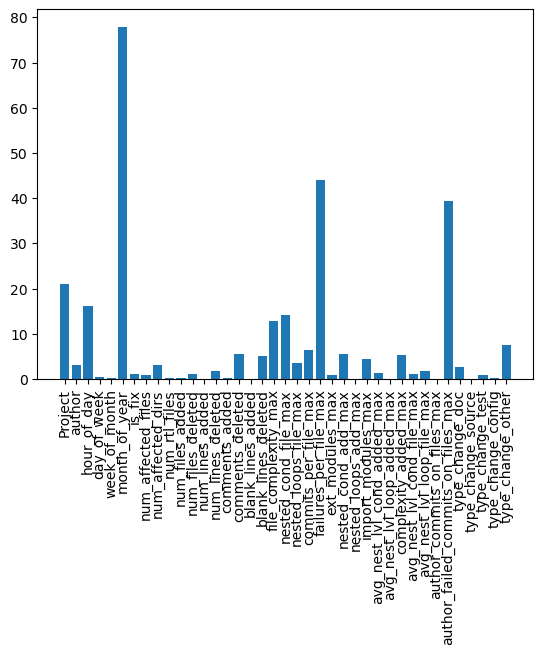

In [34]:
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression,mutual_info_classif,SelectFromModel,RFE

#### Using f_classif : ANOVA F-value between label/feature for classification tasks.
Kbest_classif = SelectKBest(score_func=f_classif, k=25)
Kbest_classif.fit(X_train, y_train)

# what are scores for the features, print Features with their scores 
#for i in range(len(Kbest_classif.scores_)):
#    print(f'Feature {i} : {round(Kbest_classif.scores_[i],3)}')

#print()

plt.bar([X_train.columns[i] for i in range(len(Kbest_classif.scores_))], Kbest_classif.scores_)
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = (8,6)
plt.show()

In [35]:
# transform training set
X_train_classif = Kbest_classif.transform(X_train)
#print("X_train.shape: {}".format(X_train.shape))
#print("X_train_selected.shape: {}".format(X_train_classif.shape))
# transform test data
X_test_classif = Kbest_classif.transform(X_test)

# Run Logistic Regression Classifier with and without Feature Reduction 
for name, model in classification_models:
    lor = model
    lor.fit(X_train, y_train)
    print(name, f'Score with all features: {round(lor.score(X_test, y_test),4)}')
    lor.fit(X_train_classif, y_train)
    print(name, f'Score with only selected features: {round(lor.score(X_test_classif, y_test),4)}')
    print()

LR Score with all features: 0.7608
LR Score with only selected features: 0.7608

KNN Score with all features: 0.7346
KNN Score with only selected features: 0.7392

SVM Score with all features: 0.7701
SVM Score with only selected features: 0.7716

Decision Tree Score with all features: 0.7716
Decision Tree Score with only selected features: 0.8056



## Step 4.3 Information Gain Classifier 

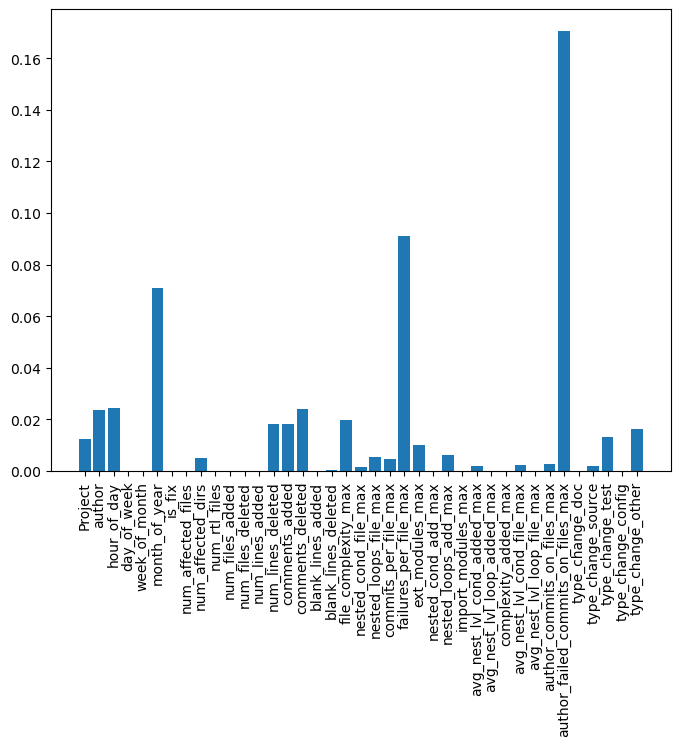

LR Score with all features: 0.7608
LR Score with only selected features: 0.7654

KNN Score with all features: 0.7346
KNN Score with only selected features: 0.7423

SVM Score with all features: 0.7701
SVM Score with only selected features: 0.7716

Decision Tree Score with all features: 0.7886
Decision Tree Score with only selected features: 0.8272



In [36]:
infogain_classif = SelectKBest(score_func=mutual_info_classif, k=25)
infogain_classif.fit(X_train, y_train)
# what are scores for the features
#for i in range(len(infogain_classif.scores_)):
#    print(f'Feature {i} : {round(infogain_classif.scores_[i],3)}')

# plot the scores
plt.bar([X_train.columns[i] for i in range(len(infogain_classif.scores_))], infogain_classif.scores_)
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = (8,6)
plt.show()

#transform train data
X_train_info_classif = infogain_classif.transform(X_train)
X_test_info_classif = infogain_classif.transform(X_test)

for name, model in classification_models:
    lor = model
    lor.fit(X_train, y_train)
    print(name, f'Score with all features: {round(lor.score(X_test, y_test),4)}')
    lor.fit(X_train_info_classif, y_train)
    print(name, f'Score with only selected features: {round(lor.score(X_test_info_classif, y_test),4)}')
    print()

## Step 4.3  Select Percentile Classifier

In [37]:
percentile = SelectPercentile(percentile=50)
percentile.fit(X_train, y_train)
# transform training set, test set
X_train_percentile = percentile.transform(X_train)
X_test_percentile = percentile.transform(X_test)

for name, model in classification_models:
    lor = model
    lor.fit(X_train, y_train)
    print(name, f'Score with all features: {round(lor.score(X_test, y_test),4)}')
    lor.fit(X_train_percentile, y_train)
    print(name, f'Score with only selected features: {round(lor.score(X_test_percentile, y_test),4)}')
    print()

LR Score with all features: 0.7608
LR Score with only selected features: 0.7654



C:\Users\m3naej\AppData\Local\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\m3naej\AppData\Local\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


KNN Score with all features: 0.7346
KNN Score with only selected features: 0.7454

SVM Score with all features: 0.7701
SVM Score with only selected features: 0.7716

Decision Tree Score with all features: 0.7855
Decision Tree Score with only selected features: 0.7963



## Step 4.4 Model-Based Feature Selection - Embedded

In [38]:
from sklearn.ensemble import RandomForestClassifier
model_based_feature = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),threshold="median")
model_based_feature.fit(X_train, y_train)
# transform training set
X_train_mbf = model_based_feature.transform(X_train)
X_test_mbf = model_based_feature.transform(X_test)

for name, model in classification_models:
    lor = model
    lor.fit(X_train, y_train)
    print(name, f'Score with only selected features: {round(lor.score(X_test, y_test),4)}')
    lor.fit(X_train_mbf, y_train)
    print(name, f'Score with only selected features: {round(lor.score(X_test_mbf, y_test),4)}')
    print()

LR Score with only selected features: 0.7608
LR Score with only selected features: 0.7562

KNN Score with only selected features: 0.7346
KNN Score with only selected features: 0.733

SVM Score with only selected features: 0.7701
SVM Score with only selected features: 0.7716

Decision Tree Score with only selected features: 0.7886
Decision Tree Score with only selected features: 0.7685



## Step 4.5 Iterative Feature Selection- Wrapper (RFE Recursive Feature Elimination , SFS Sequnetial Feature Selection)

In [39]:
#RFE Recursive Feature Elimination 
rfe_features = RFE(RandomForestClassifier(n_estimators=100, random_state=42),n_features_to_select=25)
rfe_features.fit(X_train, y_train)
X_train_rfe= rfe_features.transform(X_train)
X_test_rfe= rfe_features.transform(X_test)

In [40]:
for name, model in classification_models:
    lor = model
    lor.fit(X_train, y_train)
    print(name, f'Score with only selected features: {round(lor.score(X_test, y_test),4)}')
    lor.fit(X_train_rfe, y_train)
    print(f'Score with only selected features: {round(lor.score(X_test_rfe, y_test),4)}')
    print()

LR Score with only selected features: 0.7608
Score with only selected features: 0.7593

KNN Score with only selected features: 0.7346
Score with only selected features: 0.7377

SVM Score with only selected features: 0.7701
Score with only selected features: 0.7716

Decision Tree Score with only selected features: 0.7731
Score with only selected features: 0.7948



In [41]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select = 25)
sfs1.fit(X_train, y_train)
X_train_sfs= sfs1.transform(X_train)
X_test_sfs= sfs1.transform(X_test)

In [42]:
for name, model in classification_models:
    lor = model
    lor.fit(X_train, y_train)
    print(name, f'Score with only selected features: {round(lor.score(X_test, y_test),4)}')
    lor.fit(X_train_sfs, y_train)
    print(f'Score with only selected features: {round(lor.score(X_test_sfs, y_test),4)}')

LR Score with only selected features: 0.7608
Score with only selected features: 0.7593
KNN Score with only selected features: 0.7346
Score with only selected features: 0.7315
SVM Score with only selected features: 0.7701
Score with only selected features: 0.7731
Decision Tree Score with only selected features: 0.784
Score with only selected features: 0.7608


## Observation & Conclusion 2
![](./images/features.png)
- Decesion Tree Classifier Came as Best Classifer for our Model, Maximum Score Obtained with Information Gain Feature Selection Method with Value of 0.8117

## Step5 : Trials of Basic Classification Models 

In [43]:
classification_models = [
    ('LR', LogisticRegression(solver='liblinear')),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(gamma='auto')),
    ("Decision Tree", DecisionTreeClassifier())]

## Step 5.1 : Classifiers Comparison Using KFold Cross Validation

In [44]:
results = []
names = []
folds = 10
seed = 42
scoring = 'accuracy'

for name, model in classification_models:
    split = KFold(n_splits=folds, shuffle=True, random_state=seed)
    #clf_pipe = Pipeline([('preprocessor', preprocessor),('model', model)])
    clf_pipe = Pipeline([('model', model)])
    
    # Compute cross validation accuracy for each model
    cv_results = cross_val_score(clf_pipe, X, y, cv=split, scoring="accuracy", n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
    # output:
    min_score = round(np.min(cv_results), 4)
    max_score = round(np.max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"[{name}] Cross Validation Accuarcy Score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

[LR] Cross Validation Accuarcy Score: 0.7693 +/- 0.024 (std) min: 0.7269, max: 0.8102
[KNN] Cross Validation Accuarcy Score: 0.7406 +/- 0.0207 (std) min: 0.7083, max: 0.7778
[SVM] Cross Validation Accuarcy Score: 0.7735 +/- 0.0255 (std) min: 0.7269, max: 0.8148
[Decision Tree] Cross Validation Accuarcy Score: 0.799 +/- 0.0201 (std) min: 0.7639, max: 0.8287


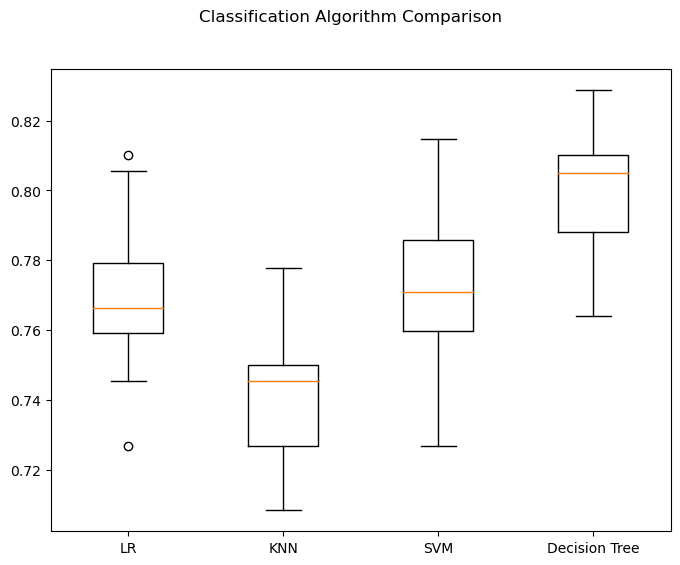

In [45]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
#plt.savefig('./images/Class_Algorith_Comparison1')

## Step 5.2 : Classifiers Comparison Using StratifiedKFold Cross Validation

In [46]:
results = []
names = []
folds = 10
seed = 42
scoring = 'accuracy'

for name, model in classification_models:
    split2 = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    clf_pipe = Pipeline([('model', model)])
    
    # Compute cross validation accuracy for each model
    cv_results = cross_val_score(clf_pipe, X, y, cv=split2, scoring="accuracy", n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
    # output:
    min_score = round(np.min(cv_results), 4)
    max_score = round(np.max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"[{name}] Cross Validation Accuarcy Score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

[LR] Cross Validation Accuarcy Score: 0.7684 +/- 0.0137 (std) min: 0.7535, max: 0.7963
[KNN] Cross Validation Accuarcy Score: 0.7402 +/- 0.0104 (std) min: 0.7222, max: 0.7546
[SVM] Cross Validation Accuarcy Score: 0.7735 +/- 0.0033 (std) min: 0.7685, max: 0.7778
[Decision Tree] Cross Validation Accuarcy Score: 0.7981 +/- 0.022 (std) min: 0.7639, max: 0.8287


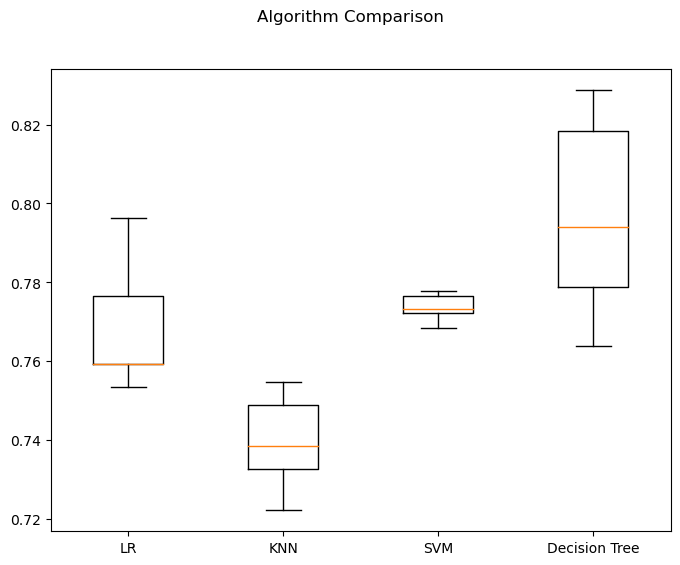

In [47]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
#plt.savefig('./images/Class_Algorith_Comparison2')

## Observation & Conclusion 3
![](./images/cv.png)
- Kfolding, StratifiedKFold with LR, SVM, KNN, DT came with conslusion that DT is best Classifier with StratifiedKFold strategy for Cross Validation with maxscore value 0.8519

## Step6: Grid Search for Hyper Parmeters Selections

### Trial6.1: GridSearch for KNN

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3, random_state=42)

In [49]:
k_range=list(range(1,10))
param_grid=dict(model__n_neighbors=k_range)
knn1 = Pipeline([('model', KNeighborsClassifier())])
scores = ['accuracy'] 
for sc in scores:
    grid_knn=GridSearchCV(knn1,param_grid,cv=10,scoring=sc,n_jobs=-1)
    print("# Tuning hyper-parameters for %s" % sc)
    grid_knn.fit(X_train,y_train)
    print(grid_knn.best_params_)
    print(np.round(grid_knn.best_score_,3))
    
## Calculate Average Fit Time 
avg_fit_time = ''
mean_fit_time= grid_knn.cv_results_['mean_fit_time']
mean_score_time= grid_knn.cv_results_['mean_score_time']
n_splits  = grid_knn.n_splits_ 
n_iter = pd.DataFrame(grid_knn.cv_results_).shape[0] #Iterations per split
avg_fit_time = np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter
print(avg_fit_time)

# Tuning hyper-parameters for accuracy
{'model__n_neighbors': 8}
0.771
12.524451971054077


In [50]:
knn_train_pred = ''
knn_test_pred = ''
knn_train_pred = grid_knn.predict(X_train)
knn_test_pred = grid_knn.predict(X_test)
knn_train_accuracy = accuracy_score(y_train, knn_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_test_pred)
print ("Knn Train Accuracy",knn_train_accuracy )
print ("Knn Test Accuracy", knn_test_accuracy)

Knn Train Accuracy 0.7928524156187955
Knn Test Accuracy 0.7608024691358025


In [51]:
### Create DataFrame
M = ['KNN', 'LR', 'SVN', 'Decesion-Tree']
Fit_Time, Train_Acc, Test_Acc = [], [], []
Fit_Time.append(avg_fit_time)
Train_Acc.append(knn_train_accuracy)
Test_Acc.append(knn_test_accuracy)

### Trial 6.2 : GridSearch for Logistic Regressions 

In [52]:
lgr = Pipeline([('model', LogisticRegression(max_iter=10000))])
param_grid = dict(model__C=[0.001, 0.01, 0.1, 1, 10, 100, 1000])
scores = ['accuracy']
for sc in scores:
    grid_lgr=GridSearchCV(lgr,param_grid,cv=10,scoring=sc,n_jobs=-1)
    print("# Tuning hyper-parameters for %s" % sc)
    grid_lgr.fit(X_train,y_train)
    print(grid_lgr.best_params_)
    print(np.round(grid_lgr.best_score_,3))

## Calculate Average Fit Time 
avg_fit_time1 = ''
mean_fit_time1= grid_lgr.cv_results_['mean_fit_time']
mean_score_time1= grid_lgr.cv_results_['mean_score_time']
n_splits1  = grid_lgr.n_splits_ 
n_iter1 = pd.DataFrame(grid_lgr.cv_results_).shape[0] #Iterations per split
avg_fit_time1 = np.mean(mean_fit_time1 + mean_score_time1) * n_splits1 * n_iter1
print(avg_fit_time1)

# Tuning hyper-parameters for accuracy
{'model__C': 1}
0.777
154.75732970237735


In [53]:
lgr_train_pred = ''
lgr_test_pred = ''
lgr_train_pred = grid_lgr.predict(X_train)
lgr_test_pred = grid_lgr.predict(X_test)
lgr_train_accuracy = accuracy_score(y_train, lgr_train_pred)
lgr_test_accuracy = accuracy_score(y_test, lgr_test_pred)
print ("LR Train Accuracy",lgr_train_accuracy )
print ("LR Test Accuracy", lgr_test_accuracy)

LR Train Accuracy 0.7888815354070152
LR Test Accuracy 0.7623456790123457


In [54]:
Fit_Time.append(avg_fit_time1)
Train_Acc.append(lgr_train_accuracy)
Test_Acc.append(lgr_test_accuracy)

### Trial 6.3 :  GridSearch for SVN

In [55]:
svc = Pipeline([('model',SVC())])
#param_grid = [{'model__kernel': ['rbf', 'linear'], 'model__gamma': [1e-3, 1e-4, 1e-5],'model__C': [1, 10, 100, 1000]}]
param_grid = dict(model__kernel=['rbf'], model__gamma=[1e-3,1e-4, 1e-5],model__C=[ 1, 10, 100])
scores = ['accuracy']
for sc in scores:
    grid_svc=GridSearchCV(svc,param_grid,cv=10,scoring=sc,n_jobs=-1)
    print("# Tuning hyper-parameters for %s" % sc)
    grid_svc.fit(X_train,y_train)
    print(grid_svc.best_params_)
    print(np.round(grid_svc.best_score_,3))
    
## Calculate Average Fit Time 
avg_fit_time2 = ''
mean_fit_time2= grid_svc.cv_results_['mean_fit_time']
mean_score_time2= grid_svc.cv_results_['mean_score_time']
n_splits2  = grid_svc.n_splits_ 
n_iter2 = pd.DataFrame(grid_svc.cv_results_).shape[0] #Iterations per split
avg_fit_time2 = np.mean(mean_fit_time2 + mean_score_time2) * n_splits2 * n_iter2
print(avg_fit_time2)

# Tuning hyper-parameters for accuracy
{'model__C': 1, 'model__gamma': 0.0001, 'model__kernel': 'rbf'}
0.779
45.228753805160515


In [56]:
svc_train_pred = ''
svc_test_pred = ''
svc_train_pred = grid_svc.predict(X_train)
svc_test_pred = grid_svc.predict(X_test)
svc_train_accuracy = accuracy_score(y_train, svc_train_pred)
svc_test_accuracy = accuracy_score(y_test, svc_test_pred)
print ("SVM Train Accuracy",svc_train_accuracy )
print ("SVM Test Accuracy", svc_test_accuracy)

SVM Train Accuracy 0.8027796161482462
SVM Test Accuracy 0.7716049382716049


In [57]:
Fit_Time.append(avg_fit_time2)
Train_Acc.append(svc_train_accuracy)
Test_Acc.append(svc_test_accuracy)

### Trial6.4: GridSearch with Decesion Tree 

In [58]:
#### Decision Tree Classification
dtree = Pipeline([('model',DecisionTreeClassifier())])
param_grid = dict(model__criterion = ['gini','entropy'],model__max_depth = [5, 10, 15, 20, 25, 30])
scores = ['accuracy'] # evaluation scores for selecting best parameter
for sc in scores:
    grid_DT = GridSearchCV(dtree,param_grid,cv=10,scoring=sc,n_jobs=-1)
    print("# Tuning hyper-parameters for %s" % sc)
    grid_DT.fit(X_train,y_train)
    print(grid_DT.best_params_)
    print(np.round(grid_DT.best_score_,3))
## Calculate Average Fit Time 
avg_fit_time3 = ''
mean_fit_time3= grid_DT.cv_results_['mean_fit_time']
mean_score_time3= grid_DT.cv_results_['mean_score_time']
n_splits3  = grid_DT.n_splits_ 
n_iter3 = pd.DataFrame(grid_DT.cv_results_).shape[0] #Iterations per split
avg_fit_time3 = np.mean(mean_fit_time3 + mean_score_time3) * n_splits3 * n_iter3
print(avg_fit_time3)

# Tuning hyper-parameters for accuracy
{'model__criterion': 'entropy', 'model__max_depth': 5}
0.831
5.1481499671936035


In [59]:
DT_train_pred = ''
DT_test_pred = ''
DT_train_pred = grid_DT.predict(X_train)
DT_test_pred = grid_DT.predict(X_test)
DT_train_accuracy = accuracy_score(y_train, DT_train_pred)
DT_test_accuracy = accuracy_score(y_test, DT_test_pred)
print ("SVM Train Accuracy",DT_train_accuracy )
print ("SVM Test Accuracy", DT_test_accuracy)

SVM Train Accuracy 0.8550628722700199
SVM Test Accuracy 0.8024691358024691


In [60]:
Fit_Time.append(avg_fit_time3)
Train_Acc.append(DT_train_accuracy)
Test_Acc.append(DT_test_accuracy)

In [61]:
### DataFrame to Compare 3 Models
Results_DF = pd.DataFrame({'Model': M, 'Train Time' : Fit_Time, 
                           'Train Accuracy' : Train_Acc, 'Test Accuracy': Test_Acc})
Results_DF

Model  Train Time  Train Accuracy  Test Accuracy
0            KNN   12.524452        0.792852       0.760802
1             LR  154.757330        0.788882       0.762346
2            SVN   45.228754        0.802780       0.771605
3  Decesion-Tree    5.148150        0.855063       0.802469

## Trial 6.5 Build Final Model Using DT, StratifiedKFold cross validation and Information Gain Feature Selection and Conclude on Results

In [62]:
from sklearn.model_selection import cross_validate
folds = 10
seed = 42
scoring = 'accuracy'
select = SelectKBest(score_func=mutual_info_classif, k=25)
model_final = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
pipeline = Pipeline([('select', select), ('DT', DecisionTreeClassifier(criterion="entropy", max_depth = 5))])
split = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
final_results = cross_validate(pipeline, X, y, cv=split, 
                scoring = ('accuracy'),
                return_estimator = True,
                return_train_score= True)

In [63]:
final_results

{'fit_time': array([0.66065431, 0.48071551, 0.44428587, 0.45873952, 0.5167799 ,
        0.50762129, 0.50553942, 0.48684573, 0.56074977, 0.57249522]),
 'score_time': array([0.00299358, 0.00299239, 0.00199246, 0.00402522, 0.00295854,
        0.00196171, 0.00398993, 0.00199556, 0.00398779, 0.00498319]),
 'estimator': [Pipeline(steps=[('select',
                   SelectKBest(k=25,
                               score_func=<function mutual_info_classif at 0x0000024D91D3B9A0>)),
                  ('DT',
                   DecisionTreeClassifier(criterion='entropy', max_depth=5))]),
  Pipeline(steps=[('select',
                   SelectKBest(k=25,
                               score_func=<function mutual_info_classif at 0x0000024D91D3B9A0>)),
                  ('DT',
                   DecisionTreeClassifier(criterion='entropy', max_depth=5))]),
  Pipeline(steps=[('select',
                   SelectKBest(k=25,
                               score_func=<function mutual_info_classif at 0x0000

[Text(0.3620689655172414, 0.9166666666666666, 'x[20] <= 0.155\nentropy = 0.768\nsamples = 1944\nvalue = [1508, 436]'),
 Text(0.10344827586206896, 0.75, 'x[15] <= 3.5\nentropy = 0.048\nsamples = 941\nvalue = [936, 5]'),
 Text(0.06896551724137931, 0.5833333333333334, 'x[16] <= 0.5\nentropy = 0.375\nsamples = 69\nvalue = [64, 5]'),
 Text(0.034482758620689655, 0.4166666666666667, 'entropy = 0.0\nsamples = 63\nvalue = [63, 0]'),
 Text(0.10344827586206896, 0.4166666666666667, 'x[0] <= 34.0\nentropy = 0.65\nsamples = 6\nvalue = [1, 5]'),
 Text(0.06896551724137931, 0.25, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.13793103448275862, 0.25, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.13793103448275862, 0.5833333333333334, 'entropy = 0.0\nsamples = 872\nvalue = [872, 0]'),
 Text(0.6206896551724138, 0.75, 'x[10] <= 5.5\nentropy = 0.986\nsamples = 1003\nvalue = [572, 431]'),
 Text(0.41379310344827586, 0.5833333333333334, 'x[2] <= 4.5\nentropy = 1.0\nsamples = 675\nvalue = [334

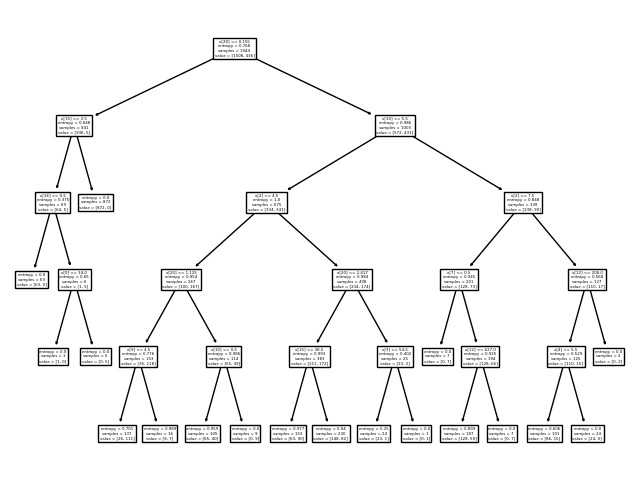

In [64]:
#print (final_results)
from sklearn import tree
fitted_DT = final_results['estimator'][9].named_steps['DT'] # choosing the first fold comb
tree.plot_tree(fitted_DT)

## Observation & Conclusion 4
- Best Model From Grid Search was Decesion Tree with Max Depth of 5 and Criterion="entropy" Using 25 Features and KFold Validation --> Test Score 0.85116279, Train Score 0.85699588

## Step7: Using Ensemble Machine Learning 

In [65]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

LR= LogisticRegression(solver='liblinear')
KNN= KNeighborsClassifier()
SVM = SVC(gamma='auto')
DT = DecisionTreeClassifier()
RF = RandomForestClassifier(n_estimators=10, random_state=42)
ET = ExtraTreesClassifier(n_estimators=10, random_state=42)
MLP = MLPClassifier(random_state=42)


estimators = [LR,KNN,SVM,DT,RF,ET,MLP]
for estimator in estimators:
    estimator.fit(X_train, y_train)
    
[estimator.score(X_test, y_test) for estimator in estimators]

[0.7608024691358025,
 0.7345679012345679,
 0.7700617283950617,
 0.779320987654321,
 0.8117283950617284,
 0.7885802469135802,
 0.7654320987654321]

## 7.1 Voting Scheme

In [66]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ('LR', LogisticRegression(solver='liblinear')),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(gamma='auto')),
    ("Dt", DecisionTreeClassifier()),
    ("RF", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("ET", ExtraTreesClassifier(n_estimators=10, random_state=42)),
    ("MLP",MLPClassifier(random_state=42))]
voting_clf = VotingClassifier(named_estimators)

In [67]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression(solver='liblinear')),
                             ('KNN', KNeighborsClassifier()),
                             ('SVM', SVC(gamma='auto')),
                             ('Dt', DecisionTreeClassifier()),
                             ('RF', RandomForestClassifier(random_state=42)),
                             ('ET',
                              ExtraTreesClassifier(n_estimators=10,
                                                   random_state=42)),
                             ('MLP', MLPClassifier(random_state=42))])

In [68]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.7608024691358025,
 0.7345679012345679,
 0.7700617283950617,
 0.7870370370370371,
 0.8333333333333334,
 0.7885802469135802,
 0.7654320987654321]

In [69]:
print ("Ensembler Voting Score", voting_clf.score(X_test, y_test))

Ensembler Voting Score 0.7762345679012346


## 7.2 Baging : Out Of Bagging Evluation

In [70]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

clf_bagging = BaggingClassifier( DecisionTreeClassifier(), n_estimators = 500, max_samples = 0.8, bootstrap = True, oob_score=True, n_jobs = -1)

# bootstrap = False (Pasting)
clf_pasting = BaggingClassifier( DecisionTreeClassifier(), n_estimators = 500, max_samples = 0.8, bootstrap = False, n_jobs = -1)

clf_bagging.fit(X_train, y_train)
clf_pasting.fit(X_train, y_train)

y_pred_bagging = clf_bagging.predict(X_test)
y_pred_pasting = clf_bagging.predict(X_test)


clf_bagging.oob_score_, accuracy_score(y_test, y_pred_bagging), accuracy_score(y_test, y_pred_pasting)

(0.8391793514228988, 0.8317901234567902, 0.8317901234567902)

In [71]:
clf_randomforest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_randomforest.fit(X_train, y_train)
y_pred_rf = clf_randomforest.predict(X_test)
print("Accuracy: " , accuracy_score(y_test, y_pred_rf))
#rf_cm = confusion_matrix(y_test, y_pred_ada)
#sns.heatmap(rf_cm , annot=True, fmt="d")

Accuracy:  0.8256172839506173


## 7.3 Boosting 

In [72]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier( DecisionTreeClassifier(max_depth=5), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
print ("Accuracy : ",  accuracy_score(y_test, y_pred_ada))

Accuracy :  0.8379629629629629


In [73]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(max_depth=5, n_estimators=200, learning_rate=1.0,random_state=42)
gbrt.fit(X_train, y_train)
y_pred_gbrt = gbrt.predict(X_test)
accuracy_score(y_test, y_pred_gbrt)

0.8333333333333334

## Step8 : Model Evluation 

Accuracy Score:  0.8302469135802469
Recall Score:  0.5067567567567568
Precision Score:  0.6696428571428571
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       500
           1       0.67      0.51      0.58       148

    accuracy                           0.83       648
   macro avg       0.77      0.72      0.74       648
weighted avg       0.82      0.83      0.82       648



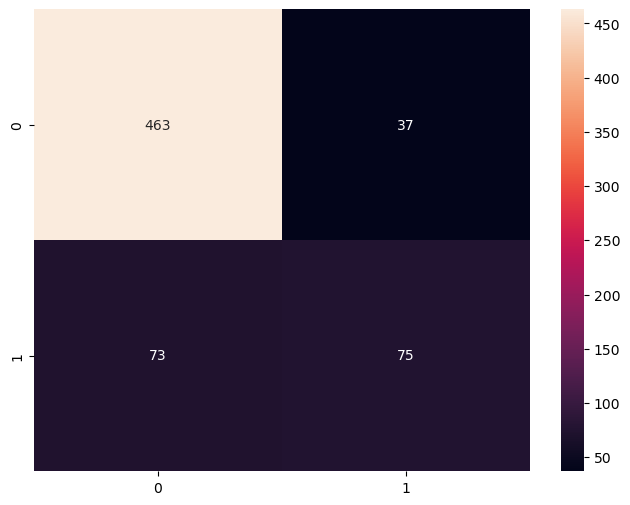

In [74]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

ada_clf = AdaBoostClassifier( DecisionTreeClassifier(max_depth=5), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)

print ("Accuracy Score: ",  accuracy_score(y_test, y_pred_ada))
print ("Recall Score: ",  recall_score(y_test, y_pred_ada))
print ("Precision Score: ",  precision_score(y_test, y_pred_ada))

# confusion_matrix
ada_cm = confusion_matrix(y_test, y_pred_ada)
sns.heatmap(ada_cm, annot=True, fmt="d")


print(classification_report(y_test, y_pred_ada))

## Summary & Final Conclusion 
- Our Work concluded that best model for Bad Code Check-Ins Prediction can be reached by using AdaBoostClassifier( DecisionTreeClassifier(max_depth=5), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5) this give us
    - 83% Accuracy , 50% Recall, 65% Precesion which was accepted as initial trial for our business problem.
- The Above Work, went through Major 8 Steps 
    - Step1: Data Exploration in which we finalize data cleaning, features types , Data size, Variance and Some Features Droping for Features at are out of scope to problem. 
    - Step2: Features Exploration, in which we examine correlation between categorical features and target variables, correlation between numerical features and their distribution 
    - Step3:Data Encoding in which we encode categorical data using label encoding, one hot encoding and scaling for numerical data. 
    - Step4:Feature Selection Iterations in which we exercise Features Filter (Variance Tests, KBest Selection, Percentile , Information Gain) as well as embedded model feature selection, or Iterative Feature Selections such as (REF, SFS) with all trials we exercised their effectiveness using Decision Tree, SVN, KNN and Logistic Regression Classifiers. 
    - Step5: Cross Validation with above 4 Classifiers using Kfold, Stratified Kfolding Techniques 
    - Step6: Grid Search for Hyper Parameters Selection : Above 3 steps demonstrates that Decision Tree with Stratified Kfolding and Kbest Select with Information Gain is best to use w.r.t accuracy score , yet to select best parameters for these models we ran Grid search to search for best Hyper Parameters for DT came as Tree with max depth = 5 and criteria of entropy 
    - Step7: we exercise ensemble techniques such as voting, boosting and Bagging using more of mini classifiers such as Random Forest, Extra Tree, MLP Classifier + original four classifiers, again Voting did not produce better results, out of bagging and boosting improve the accuracy to 83% 
    - Step8: Final Model Creation and Evaluation, her we picked ada boost as selected classifiers All Observations and conclusions are listed in every Section

  